In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import time

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

In [2]:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [3]:
# data for panel (a)
ddir = base_dir+'test/confvsacc/'
EXP_NAME = 'exp2'
EXP_NAME2 = 'exp2_retrain' 

# green
finame = 'confvsacc_ann1_60Eshift_'+EXP_NAME+'.npy'
ann1_acc = np.load(ddir+finame)
ann1_acc[ann1_acc==0] = np.nan

# grey
finame = 'confvsacc_ann1_noshift_'+EXP_NAME+'.npy'
ann1_acc_noshift = np.load(ddir+finame)
ann1_acc_noshift[ann1_acc_noshift==0] = np.nan

# teal
finame = 'confvsacc_ann2_60Eshift_'+EXP_NAME2+'.8_ann1-'+EXP_NAME+'.npy'
ann2_acc = np.load(ddir+finame)
ann2_acc[ann2_acc==0] = np.nan

# --- ANN1
ann1_acc_avg = np.nanmedian(ann1_acc,axis=0)
ann1_acc_min = np.nanmin(ann1_acc,axis=0)
ann1_acc_max = np.nanmax(ann1_acc,axis=0)

ann1_acc_noshift_avg = np.nanmedian(ann1_acc_noshift,axis=0)
ann1_acc_noshift_min = np.nanmin(ann1_acc_noshift,axis=0)
ann1_acc_noshift_max = np.nanmax(ann1_acc_noshift,axis=0)

# --- ANN2
ann2_acc_avg = np.nanmedian(ann2_acc,axis=0)
ann2_acc_min = np.nanmin(ann2_acc,axis=0)
ann2_acc_max = np.nanmax(ann2_acc,axis=0)

### Data for "number of retraining members required" histogram:

In [4]:
# number of retraining members needed for all predictions:
per = 0
mems_needed_all = []
per_conf = -20
mems_needed_conf = []

EXP_NAME = 'exp2_kfold'
EXP_NAME2 = 'exp2_retrain_increase_kfold'

for kk in range(20):
    finame = 'confvsacc_ann1_60Eshift_'+EXP_NAME+'.'+str(kk)+'.npy'
    ann1_acc_kfold = np.load(base_dir+'test/confvsacc/kfold/'+finame)
    ann1_acc_kfold[ann1_acc_kfold==0] = np.nan
    
    quartile1_ann1, median_ann1 = np.percentile(ann1_acc_kfold[:,per], [25,50], axis=0)
    quartile1_ann1_conf, median_ann1_conf = np.percentile(ann1_acc_kfold[:,per_conf], [25,50], axis=0)
    
    quartile3_loop = []
    quartile3_loop_conf = []
    for i_trainmems in range(9):
        finame = 'confvsacc_ann2_60Eshift_'+EXP_NAME2+'.'+str(kk)+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'.npy'
        ann2_acc_kfold = np.load(base_dir+'test/confvsacc/kfold/'+finame)
        ann2_acc_kfold[ann2_acc_kfold==0] = np.nan
    
        quartile1_ann2, median_ann2, quartile3_ann2 = np.percentile(ann2_acc_kfold[:,per], [25,50,75], axis=0)
        quartile1_ann2_conf, median_ann2_conf, quartile3_ann2_conf = np.percentile(ann2_acc_kfold[:,per_conf], [25,50,75], axis=0)
        
        quartile3_loop.append(quartile3_ann2)
        quartile3_loop_conf.append(quartile3_ann2_conf)

    temp_val = list(np.where(quartile3_loop >= quartile1_ann1)[0])
    if len(temp_val) > 0:
        mems_needed_all.append(temp_val[0]+1)
    else:
        mems_needed_all.append(10)

    temp_val_conf = list(np.where(quartile3_loop_conf >= quartile1_ann1_conf)[0])
    if len(temp_val_conf) > 0:
        mems_needed_conf.append(temp_val_conf[0]+1)
    else:
        mems_needed_conf.append(10)

### PLOT

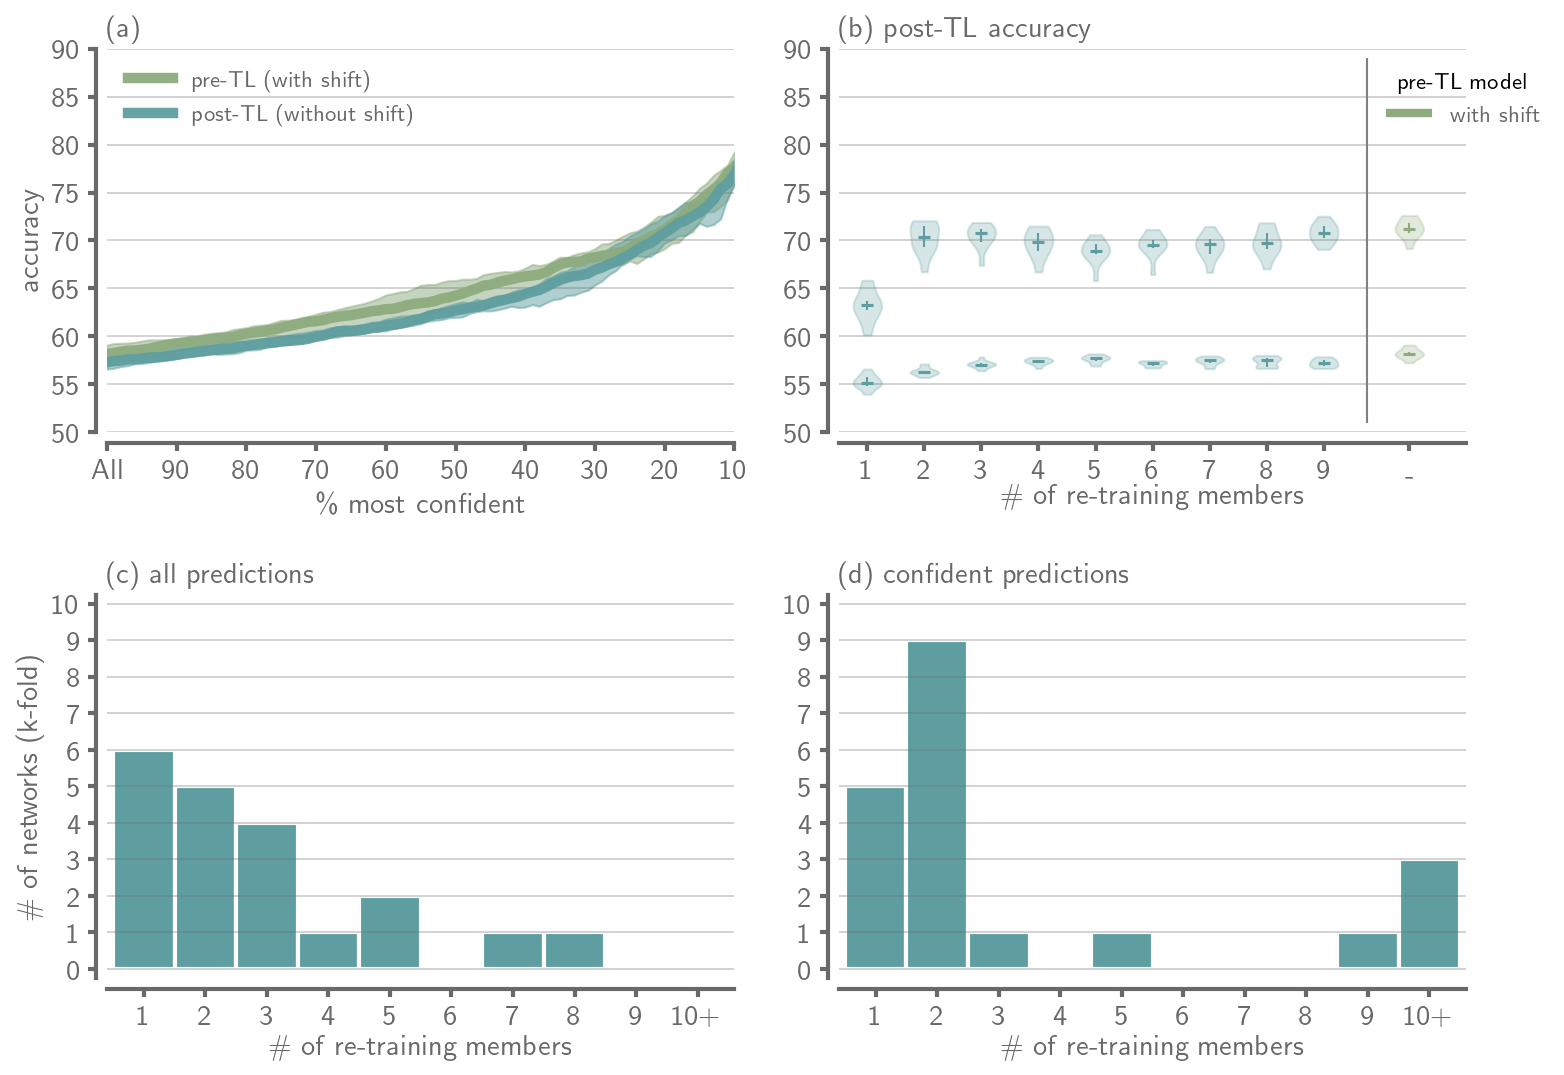

In [10]:
# -- PLOT
cesmcolor = 'k'
allobscolor = 'darkslateblue'
preTLcolor = (141/255,171/255,127/255,1.)
postTLcolor = 'cadetblue'
diffcolor = 'grey'
FS = 14

fig = plt.figure(figsize=(10,7))
ax = fig.subplot_mosaic('''
                        AB
                        CD
                        ''')
plt.tight_layout(w_pad=1,h_pad=3.5)

for loc in ['A','B','C','D']:
    adjust_spines(ax[loc], ['left', 'bottom'])
    ax[loc].spines['top'].set_color('none')
    ax[loc].spines['right'].set_color('none')
    ax[loc].spines['left'].set_color('dimgrey')
    ax[loc].spines['bottom'].set_color('dimgrey')
    ax[loc].spines['left'].set_linewidth(2)
    ax[loc].spines['bottom'].set_linewidth(2)
    ax[loc].tick_params('both',length=4,width=2,which='major',color='dimgrey')
    ax[loc].yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

    if loc == 'A':
        ax[loc].set_ylim(50,90)
        ax[loc].set_xlim(0,90)
        ax[loc].set_ylabel('accuracy',fontsize=FS,color='dimgrey')
        ax[loc].set_yticks(np.arange(50,95,5),labels=np.arange(50,95,5),fontsize=FS,color='dimgrey')
        ax[loc].set_xticks(np.arange(0,100,10),['All',90,80,70,60,50,40,30,20,10],fontsize=FS,color='dimgrey')
        ax[loc].set_xlabel('\% most confident',fontsize=FS,color='dimgrey')
    elif loc in ['C','D']:
        ax[loc].set_ylim(-0.25,10.25)
        ax[loc].set_xlim(0.4,10.6)
        if loc == 'C':
            ax[loc].set_ylabel('\# of networks (k-fold)',fontsize=FS,color='dimgrey')
        ax[loc].set_yticks(np.arange(0,11,1),labels=np.arange(0,11,1),fontsize=FS,color='dimgrey')
        ax[loc].set_xticks(np.arange(1,11), ['1','2','3','4','5','6','7','8','9','10$+$'],fontsize=FS,color='dimgrey',rotation=0)
        ax[loc].set_xlabel('\# of re-training members',fontsize=FS,color='dimgrey', labelpad=2) 
    elif loc == 'B':
        ax[loc].set_ylim(50,90)
        ax[loc].set_xlim(0,110)
        # ax[loc].set_ylabel('accuracy',fontsize=FS+3,color='dimgrey')
        ax[loc].set_yticks(np.arange(50,95,5),labels=np.arange(50,95,5),fontsize=FS,color='dimgrey')
        ax[loc].set_xticks([5,15,25,35,45,55,65,75,85,100],[1, 2, 3, 4, 5, 6, 7, 8, 9, '-'],fontsize=FS,color='dimgrey',rotation=0)
        ax[loc].set_xlabel('\# of re-training members',fontsize=FS,color='dimgrey', loc='center', labelpad=0)
    
# -----------------------------------
# ----- panel (a) -----
# -----------------------------------
ax['A'].set_title('(a)',fontsize=FS,color='dimgrey', loc='left')
ax['A'].fill_between(np.arange(0,100,1),ann1_acc_min,ann1_acc_max,color=preTLcolor, alpha=0.5)
# ax['A'].fill_between(np.arange(0,100,1),ann1_acc_noshift_min,ann1_acc_noshift_max,color='grey', alpha=0.5)
ax['A'].fill_between(np.arange(0,100,1),ann2_acc_min,ann2_acc_max,color=postTLcolor, alpha=0.5)

ax['A'].plot(ann1_acc_avg, '-', color=preTLcolor, alpha=0.95,linewidth=5,label='pre-TL (with shift)')
# ax['A'].plot(ann1_acc_noshift_avg, '-', color='grey', alpha=0.95,linewidth=5,label='pre-TL (without shift)')
ax['A'].plot(ann2_acc_avg, '-', color=postTLcolor, alpha=0.95,linewidth=5,label='post-TL (without shift)')

ax['A'].legend(frameon=False, fontsize=FS-3, labelcolor='dimgrey', loc='upper left',ncol=1)

# -----------------------------------
# ----- panel (b) -----
# -----------------------------------
EXP_NAME = 'exp2'
EXP_NAME2 = 'exp2_retrain_increase' 

ax['B'].set_title('(b) post-TL accuracy',fontsize=FS,color='dimgrey', loc='left')
# ax['B'].set_title('(b) Accuracy vs \# of Re-training Members',fontsize=FS,color='dimgrey', loc='left')
positions = [[5],[15],[25],[35],[45],[55],[65],[75],[85],[100]]
# ----- pre-TL (with shift) -----
vp_all = ax['B'].violinplot(ann1_acc[:,0],
                     positions =positions[-1],
                     widths=5,
                     showmeans=False, showmedians=False,showextrema=False)

vp_conf = ax['B'].violinplot(ann1_acc[:,per_conf],
                     positions =positions[-1],
                     widths=5,
                     showmeans=False, showmedians=False,showextrema=False)

for b in vp_all['bodies']:
    b.set_facecolor(preTLcolor)
    b.set_edgecolor(preTLcolor)
    b.set_alpha(0.25)

for b in vp_conf['bodies']:
    b.set_facecolor(preTLcolor)
    b.set_edgecolor(preTLcolor)
    b.set_alpha(0.25)

quartile1, median, quartile3 = np.percentile(ann1_acc[:,0], [25, 50, 75], axis=0)
ax['B'].scatter(positions[-1], median, marker='_', color=preTLcolor, s=30, zorder=3)
ax['B'].vlines(positions[-1], quartile1, quartile3, color=preTLcolor, linestyle='-', lw=1)

quartile1, median, quartile3 = np.percentile(ann1_acc[:,per_conf], [25, 50, 75], axis=0)
ax['B'].scatter(positions[-1], median, marker='_', color=preTLcolor, s=30, zorder=3)
ax['B'].vlines(positions[-1], quartile1, quartile3, color=preTLcolor, linestyle='-', lw=1, label='with shift')

ax['B'].vlines(92.5, 51, 89, color='grey', linestyle='-', lw=1)

# ----- pre-TL -----
# vp_all = ax['B'].violinplot(ann1_acc_noshift[:,0],
#                      positions =positions[-1],
#                      widths=5,
#                      showmeans=False, showmedians=False,showextrema=False)

# vp_conf = ax['B'].violinplot(ann1_acc_noshift[:,per_conf],
#                      positions =positions[-1],
#                      widths=5,
#                      showmeans=False, showmedians=False,showextrema=False)

# for b in vp_all['bodies']:
#     b.set_facecolor('grey')
#     b.set_edgecolor('grey')
#     b.set_alpha(0.25)

# for b in vp_conf['bodies']:
#     b.set_facecolor('grey')
#     b.set_edgecolor('grey')
#     b.set_alpha(0.25)

# quartile1, median, quartile3 = np.percentile(ann1_acc_noshift[:,0], [25, 50, 75], axis=0)
# ax['B'].scatter(positions[-1], median, marker='_', color='grey', s=30, zorder=3)
# ax['B'].vlines(positions[-1], quartile1, quartile3, color='grey', linestyle='-', lw=1)

# quartile1, median, quartile3 = np.percentile(ann1_acc_noshift[:,per_conf], [25, 50, 75], axis=0)
# ax['B'].scatter(positions[-1], median, marker='_', color='grey', s=30, zorder=3)
# ax['B'].vlines(positions[-1], quartile1, quartile3, color='grey', linestyle='-', lw=1,label='without shift')

# ----- retraining member post-TL loop -----
for i_trainmems in range(9):
    finame = 'confvsacc_ann2_60Eshift_'+EXP_NAME2+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'.npy'
    ann2_acc_exp3_loop = np.load(ddir+finame)
    ann2_acc_exp3_loop[ann2_acc_exp3_loop==0] = np.nan

    
    vp_all = ax['B'].violinplot(ann2_acc_exp3_loop[:,0],
                            positions =positions[i_trainmems],
                            widths=5,
                            showmeans=False, showmedians=False,showextrema=False)

    vp_conf = ax['B'].violinplot(ann2_acc_exp3_loop[:,per_conf],
                            positions =positions[i_trainmems],
                            widths=5,
                            showmeans=False, showmedians=False,showextrema=False)
    
    for b in vp_all['bodies']:
        b.set_facecolor(postTLcolor)
        b.set_edgecolor(postTLcolor)
        b.set_alpha(0.25)

    for b in vp_conf['bodies']:
        b.set_facecolor(postTLcolor)
        b.set_edgecolor(postTLcolor)
        b.set_alpha(0.25)
        
    quartile1, median, quartile3 = np.percentile(ann2_acc_exp3_loop[:,0], [25, 50, 75], axis=0)
    ax['B'].scatter(positions[i_trainmems], median, marker='_', color=postTLcolor, s=30, zorder=3)
    ax['B'].vlines(positions[i_trainmems], quartile1, quartile3, color=postTLcolor, linestyle='-', lw=1)

    quartile1, median, quartile3 = np.percentile(ann2_acc_exp3_loop[:,per_conf], [25, 50, 75], axis=0)
    ax['B'].scatter(positions[i_trainmems], median, marker='_', color=postTLcolor, s=30, zorder=3)
    ax['B'].vlines(positions[i_trainmems], quartile1, quartile3, color=postTLcolor, linestyle='-', lw=1)

legb = ax['B'].legend(frameon=False, fontsize=FS-3,
                      labelcolor='dimgrey',
                      bbox_to_anchor=(1.15, 0.99),
                      # loc='upper right', 
                      ncol=1,
                      title='pre-TL model',title_fontsize=FS-3)
for line in legb.get_lines():
    line.set_linewidth(4.0)
#
ax['C'].hist(mems_needed_all, bins=10,range=(1,11),cumulative=False,
             align='left',histtype='bar',color=postTLcolor, linewidth=2,edgecolor='w')
ax['C'].set_title('(c) all predictions',fontsize=FS,color='dimgrey', loc='left')
# ax['C'].hlines(y=10,xmin=0,xmax=11,color='dimgrey',linestyles='dashed')

ax['D'].hist(mems_needed_conf, bins=10,range=(1,11),cumulative=False,
             align='left',histtype='bar',color=postTLcolor, linewidth=2,edgecolor='w')
ax['D'].set_title('(d) confident predictions',fontsize=FS,color='dimgrey', loc='left')
# ax['D'].hlines(y=10,xmin=0,xmax=11,color='dimgrey',linestyles='dashed')

# plt.show()
plt.savefig('plots/Figure2.png', dpi=300, transparent = True, bbox_inches = 'tight')